{'dx': 230, 'dy': 205, 'x0': 170, 'y0': 50}
(205, 230, 3)
(102, 29)
(2958,)
49.0
steps -90.0 aligned: False
G10 L20 P1 Y0
G1 Y-90 F20000



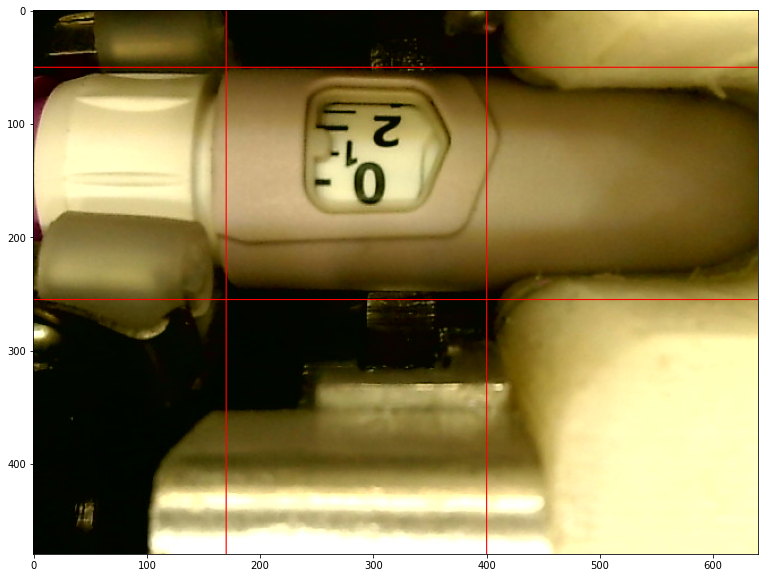

In [3]:
import json
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
import sklearn
from clean_for_training import prepare_frame


def load_data():
    with open('annotaion.json') as f:
        data = json.loads(f.read())
    return data

node = '101'
component = 'dosing'

data = load_data()
roi = data[node][component + '_roi']
print(roi)
''' show image '''
img_org = cv2.imread('../dump/%s_192.168.44.%s.png' % (component, node))
img = img_org.copy()[:,:,::-1]
img[roi['y0'],:] = [255,0,0]
img[roi['y0']+roi['dy'],:] = [255,0,0]
img[:,roi['x0']] = [255,0,0]
img[:,roi['x0']+roi['dx']] = [255,0,0]

plt.figure(figsize=(18, 10))
plt.imshow(img)


clf = pickle.load(open('../../models/%s_%s.clf'%(component, node), 'rb'))

frame = prepare_frame(img_org, roi, component)
print(frame.shape)
cls = clf.predict([frame])[0]
print(cls)


# coefs = np.array([j.base_estimator.coef_ for j in clf.calibrated_classifiers_]).mean(axis=0)
# coefs = coefs.reshape(coefs.shape[0], roi['dy'], -1)

# for i in range(coefs.shape[0]):
#     plt.figure(i)
#     plt.imshow(coefs[i])
#     plt.show()


step_per_rev = 360
class_per_rev = 100
p = 1.0 / class_per_rev * step_per_rev
cls = cls-2
if cls <= 0:
    cls = -cls
elif cls <= 33:
    cls = class_per_rev - cls
else:
    cls = 25

steps = -cls * p
aligned = bool(abs(cls) < 3)  # np.bool_ to bool
print('steps', steps, 'aligned:', aligned)

axis = {'holder': 'X', 'dosing': 'Y'}[component]
command = ''
command += 'G10 L20 P1 %s0\n' % axis
command += 'G1 %s%d F20000\n' % (axis, steps)
print(command)

(205, 230, 3)
(205, 230, 3)
(102, 29)
49.0


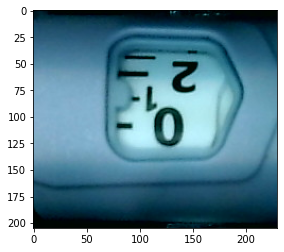

In [16]:
frame = cv2.imread('../dump/data/a.png')
print(frame.shape)
plt.imshow(frame)

def prepare_frame(frame, component):
    if component == 'dosing':
        x_downsample = 8
        y_downsample = 2
    elif component == 'holder':
        x_downsample = 2
        y_downsample = 8
    else:
        raise

    x_size = round(frame.shape[1] / x_downsample)
    y_size = round(frame.shape[0] / y_downsample)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame = cv2.resize(frame, (x_size, y_size), interpolation=cv2.INTER_AREA)

    frame = frame.flatten()
    return frame

def prepare_frame2(frame, component):
    if component == 'dosing':
        x_downsample = 8
        y_downsample = 2
    elif component == 'holder':
        x_downsample = 2
        y_downsample = 8
    else:
        raise

    x0 = roi['x0']
    x1 = roi['x0'] + roi['dx']
    y0 = roi['y0']
    y1 = roi['y0'] + roi['dy']
    x_size = round(frame.shape[1] / x_downsample)
    y_size = round(frame.shape[0] / y_downsample)

    #frame = frame[y0:y1, x0:x1, :]
    print(frame.shape)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (x_size, y_size), interpolation=cv2.INTER_AREA)
    print(frame.shape)

    # plt.imshow(frame)
    # plt.show()
    # raise

    frame = frame.flatten()
    return frame

frame = prepare_frame2(frame, component)
cls = clf.predict([frame])[0]
print(cls)